In [ ]:
import logging
import warnings

warnings.filterwarnings('ignore')

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)
logging.getLogger("lightning_fabric").setLevel(logging.CRITICAL)

logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.CRITICAL)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.CRITICAL)

In [ ]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 49.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.numpy import mae, rmse, smape, mape

Leio os meus dados

In [ ]:
def parse_tsf(file_path, frequency='D'):
    data = []
    start_found = False
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip().startswith("@data"):
                start_found = True
                continue
            if not start_found or not line.strip():
                continue

            parts = line.strip().split(':')
            series_name = parts[0]
            start_timestamp = parts[1].strip()[:10]
            values = parts[-1].split(',')

            try:
                start = pd.Timestamp(start_timestamp)
            except:
                start = pd.Timestamp.now()

            dates = pd.date_range(start=start, periods=len(values), freq=frequency)

            for date, val in zip(dates, values):
                val = np.nan if val == '?' else float(val)
                data.append([series_name, date, val])

    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

In [ ]:
def filtrar_serie(df, id_serie=None):
    unique_ids = df['unique_id'].unique()

    if id_serie is None:
        escolhida = unique_ids[0]
    else:
        escolhida = id_serie

    return df[df['unique_id'] == escolhida].copy()

In [ ]:
def run_patchtst(df, horizon, frequency='D'):
    y_test = df.groupby('unique_id').tail(horizon)
    y_train = df.drop(y_test.index)

    models = [
        PatchTST(h=horizon,
                 input_size=horizon*3,
                 max_steps=300,
                 scaler_type='minmax',
                 enable_progress_bar=True,
                 enable_model_summary=False,
                 logger = False,
                 enable_checkpointing=False)
    ]

    nf = NeuralForecast(models=models, freq=frequency)
    nf.fit(df=y_train)
    y_pred = nf.predict().reset_index()

    return y_test, y_pred

In [ ]:
def calculate_metrics(y_test, y_hat):
    results = y_test.merge(y_hat, on=['unique_id', 'ds'], how='left')
    y_real = results['y'].values
    y_pred = results['PatchTST'].values

    mae_val = mae(y_real, y_pred )
    rmse_val = rmse(y_real, y_pred )
    mape_val = mape(y_real, y_pred)
    smape_val = smape(y_real, y_pred)
    return mae_val, rmse_val, mape_val, smape_val

In [ ]:
import matplotlib.pyplot as plt
def plot_forecast(results):
    uid = results['unique_id'].unique()[0]
    plt.figure(figsize=(10, 5))
    plt.plot(results['ds'], results['y'], label='Real (Teste)', marker='o')
    plt.plot(results['ds'], results['PatchTST'], label='Previsão PatchTST', linestyle='--', marker='x')
    plt.title(f"Previsão vs Real: {uid}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Output()

Output()

MAE: 5.94
RMSE: 6.93
SMAPE: 0.56


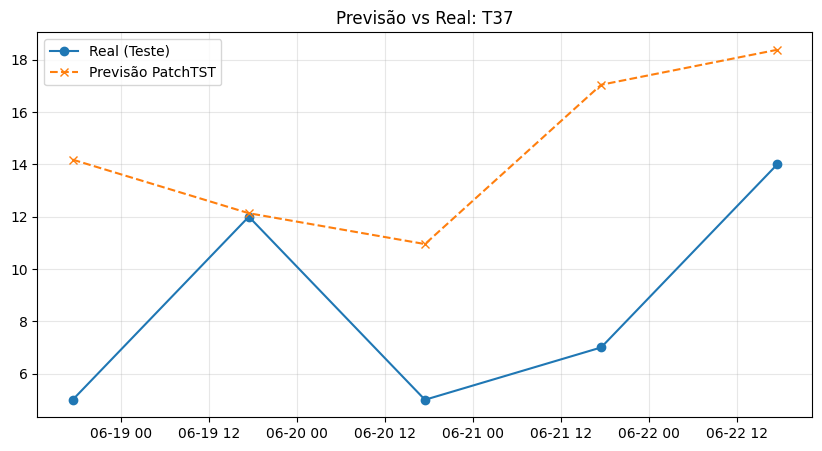

In [ ]:
df = parse_tsf('vehicle_trips_dataset_without_missing_values.tsf', frequency='D')
df_filtrado = filtrar_serie(df, id_serie="T37")
y_test, y_hat = run_patchtst(df_filtrado, 5)
mae_val, rmse_val, mape_val, smape_Vale = calculate_metrics(y_test, y_hat)
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"SMAPE: {smape_Vale:.2f}")
plot_forecast(y_test.merge(y_hat, on=['unique_id', 'ds'], how='left'))


Venda de peças de automóveis

Output()

Output()

MAE: 0.29
RMSE: 0.44
SMAPE: 1.96


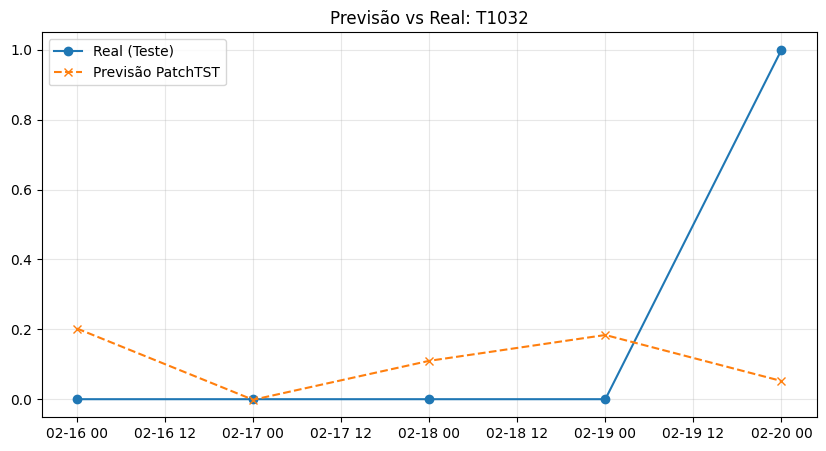

In [ ]:
df = parse_tsf('car_parts_dataset_without_missing_values.tsf')
df_filtrado = filtrar_serie(df, id_serie = "T1032")
y_test, y_hat = run_patchtst(df_filtrado, 5)
mae_val, rmse_val, mape_val, smape_val = calculate_metrics(y_test, y_hat)
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"SMAPE: {smape_val:.2f}")
plot_forecast(y_test.merge(y_hat, on=['unique_id', 'ds'], how='left'))

Preço do bitcoin

Output()

Output()

MAE: 448.44
RMSE: 684.06
MAPE: 0.0146
SMAPE: 0.0144


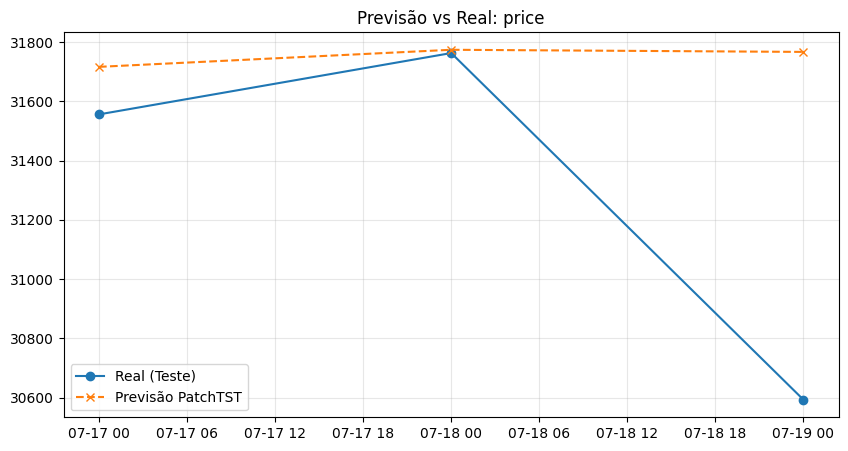

In [ ]:
df = parse_tsf('bitcoin_dataset_without_missing_values.tsf')
df_filtrado = filtrar_serie(df, id_serie= 'price')
y_test, y_hat = run_patchtst(df_filtrado, 3)
mae_val, rmse_val, mape_val, smape_val = calculate_metrics(y_test, y_hat)
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.4f}")
print(f"SMAPE: {smape_val:.4f}")
plot_forecast(y_test.merge(y_hat, on=['unique_id', 'ds'], how='left'))

Saques em caixa eletrônico

Output()

Output()

MAE: 0.96
RMSE: 1.14
MAPE: 0.11


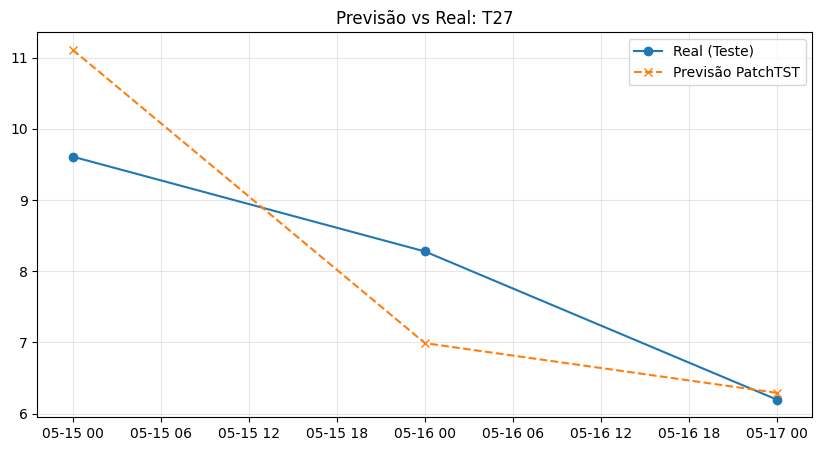

In [ ]:
df = parse_tsf('nn5_daily_dataset_without_missing_values.tsf', frequency = 'D')
df_filtrado = filtrar_serie(df, id_serie="T27")
y_test, y_hat = run_patchtst(df_filtrado, 3)
mae_val, rmse_val, mape_val, smape_val = calculate_metrics(y_test, y_hat)
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}")
plot_forecast(y_test.merge(y_hat, on=['unique_id', 'ds'], how='left'))

Manchas solares, o sol tem um ciclo de 11 anos, por isso o crescimento abrupto

Output()

Output()

MAE: 0.40
RMSE: 0.89
SMAPE: 2.00


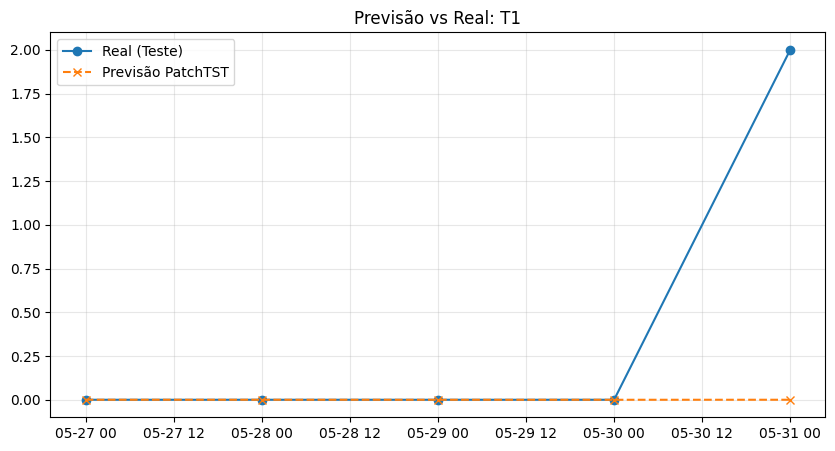

In [ ]:
df = parse_tsf('sunspot_dataset_without_missing_values.tsf')
df_filtrado = filtrar_serie(df)
y_test, y_hat = run_patchtst(df_filtrado, 5)
mae_val, rmse_val, mape_val, smape_val = calculate_metrics(y_test, y_hat)
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"SMAPE: {smape_val:.2f}")
plot_forecast(y_test.merge(y_hat, on=['unique_id', 'ds'], how='left'))